# Importando bibliotecas importantes

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import keras
import numpy as np

In [2]:
%matplotlib notebook 
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

### Bibliotecas pessoais

In [4]:
from dataHandler import dataHandler

# Carregando dados

In [5]:
data = dataHandler()
data.loadData("data/")

### Codificando labels via One Hot Encoding

In [6]:
data.oneHotEncode()

In [7]:
print("- Foram detectadas %d classes diferentes" % data.getClassCount())
print(data.classes)

- Foram detectadas 41 classes diferentes
['(' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'T' 'Y' '_' 'a' 'b' 'd' 'e' 'g' 'h' 'i' 'j' 'k' 'm' 'n' 'q' 'r' 's' 't'
 'u' 'v' 'w' 'x' 'z']


### Reformatação das features em caso de usar CNN

In [8]:
data.reshapeInputs()

### Obtendo dados
Os dados de treino e teste são divididos durante o carregamento

In [9]:
train_features, test_features = data.getFeatures()
train_labels, test_labels = data.getLabels()

### Visualizando dados

<IPython.core.display.Javascript object>


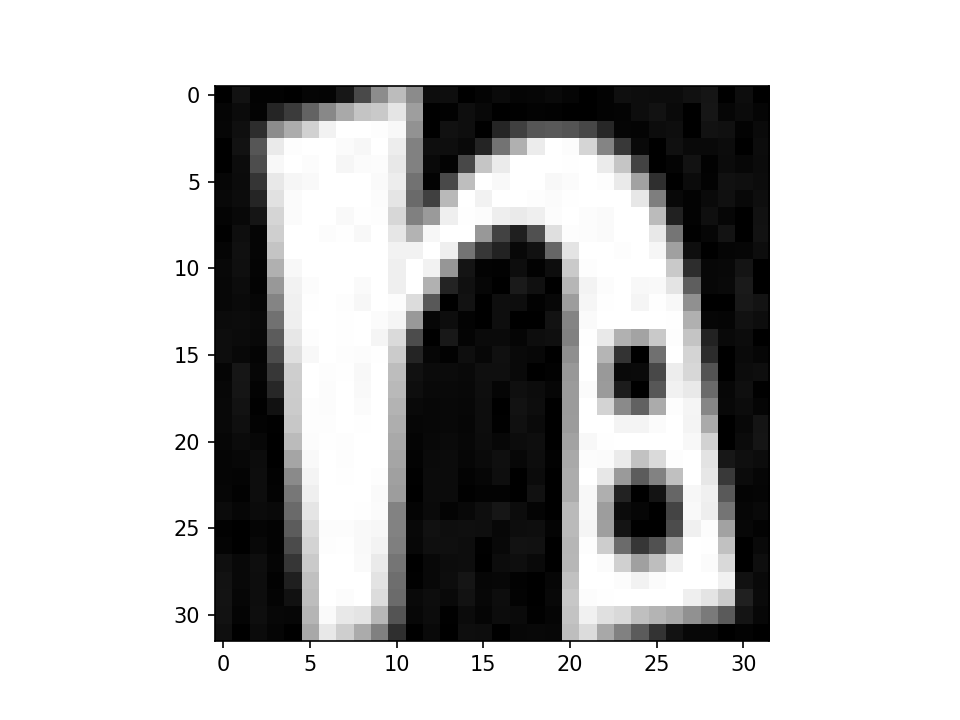

<IPython.core.display.Javascript object>


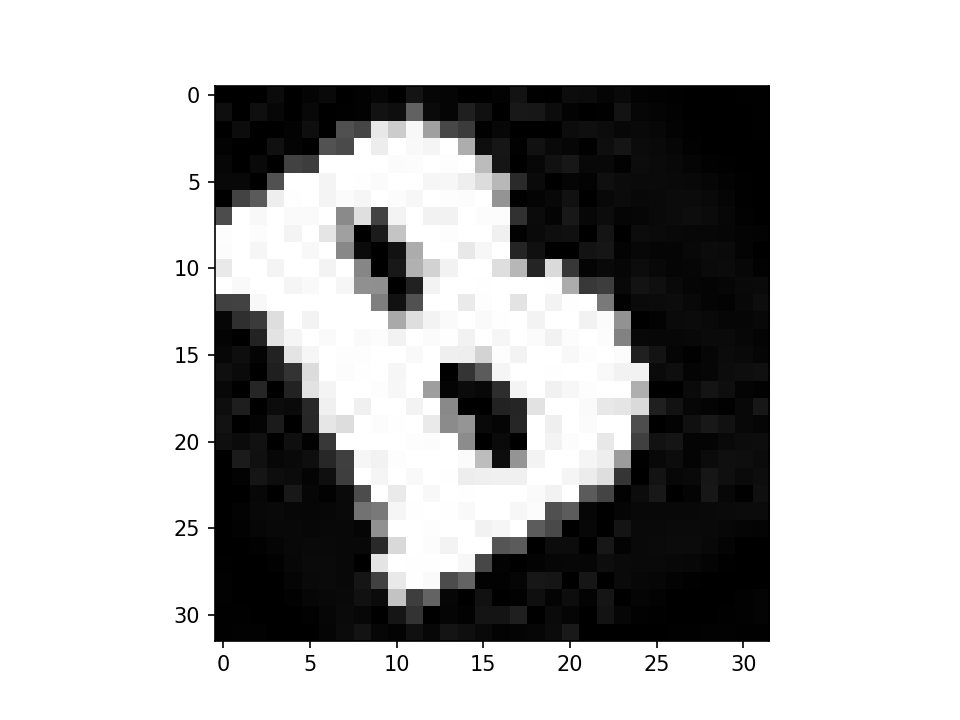

In [10]:
img1 = Image.fromarray(train_features[4].reshape(32,32))
img2 = Image.fromarray(train_features[5].reshape(32,32))

plt.figure()
plt.imshow(img1, cmap='gray')
plt.figure()
plt.imshow(img2, cmap='gray')

In [11]:
print(data.oneHotDecode(train_labels[4]))
print(data.oneHotDecode(train_labels[5]))

n
B


In [12]:
print("- Tamanho do conjunto de treino: %d" % len(train_features))
print("- Tamanho do conjunto de teste: %d" % len(test_features))

- Tamanho do conjunto de treino: 131200
- Tamanho do conjunto de teste: 32800


# Criando rede neural

In [13]:
inputShape = train_features[0].shape[0]
numClasses = data.getClassCount()

print("- Tamanho linear dos dados de entrada: %d" % inputShape)

- Tamanho linear dos dados de entrada: 32


### MLP

In [137]:
model = keras.Sequential()
model.add(keras.layers.Dense(512, input_dim=inputShape, activation='selu'))
model.add(keras.layers.Dropout(0.8))

model.add(keras.layers.Dense(256, input_dim=inputShape, activation='selu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(256, input_dim=inputShape, activation='selu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(256, input_dim=inputShape, activation='selu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(numClasses, activation="softmax"))

### CNN

In [14]:
model = keras.Sequential()

model.add(keras.layers.Lambda(lambda image: image * (1/255.0), input_shape = (inputShape,inputShape,1)))

model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,1)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(numClasses, activation='softmax'))

In [172]:
'''model = keras.Sequential()

model.add(keras.layers.Lambda(lambda image: image * (1/255.0), input_shape = (inputShape,inputShape,1)))

model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='selu'))
#model.add(keras.layers.Dense(512, activation='selu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(numClasses, activation='softmax'))'''

"model = keras.Sequential()\n\nmodel.add(keras.layers.Lambda(lambda image: image * (1/255.0), input_shape = (inputShape,inputShape,1)))\n\nmodel.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))\nmodel.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))\nmodel.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))\nmodel.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))\nmodel.add(keras.layers.Dropout(0.25))\n\nmodel.add(keras.layers.Flatten())\nmodel.add(keras.layers.Dense(512, activation='selu'))\n#model.add(keras.layers.Dense(512, activation='selu'))\nmodel.add(keras.layers.Dropout(0.5))\n\nmodel.add(keras.layers.Dense(numClasses, activation='softmax'))"

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 29, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 29, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 27, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 13, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 13, 64)         0

## Compilando modelo

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Checkpoint

In [17]:
checkDir = "checkpoint/"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkDir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Treinando modelo

In [18]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=128,
                    validation_data=(test_features, test_labels), callbacks=[model_checkpoint_callback])

Epoch 1/30
1025/1025 [==============================] - 45s 42ms/step - loss: 2.0028 - accuracy: 0.4474 - val_loss: 0.6324 - val_accuracy: 0.8650
Epoch 2/30
1025/1025 [==============================] - 43s 42ms/step - loss: 0.5768 - accuracy: 0.8216 - val_loss: 0.5995 - val_accuracy: 0.9020
Epoch 3/30
1025/1025 [==============================] - 43s 42ms/step - loss: 0.4268 - accuracy: 0.8668 - val_loss: 0.5666 - val_accuracy: 0.9114
Epoch 4/30
1025/1025 [==============================] - 43s 42ms/step - loss: 0.3603 - accuracy: 0.8860 - val_loss: 0.5598 - val_accuracy: 0.9219
Epoch 5/30
1025/1025 [==============================] - 43s 42ms/step - loss: 0.3142 - accuracy: 0.8999 - val_loss: 0.5563 - val_accuracy: 0.9197
Epoch 6/30
1025/1025 [==============================] - 43s 42ms/step - loss: 0.2938 - accuracy: 0.9065 - val_loss: 0.5696 - val_accuracy: 0.9244
Epoch 7/30
1025/1025 [==============================] - 43s 42ms/step - loss: 0.2719 - accuracy: 0.9139 - val_loss: 0.5074 -

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


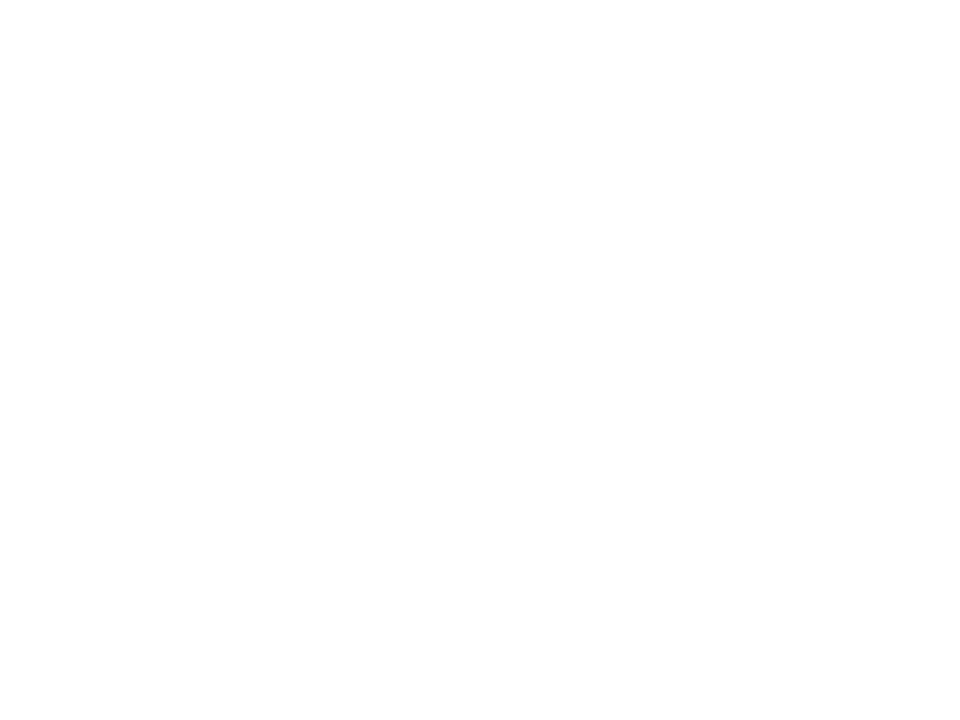

NameError: name 'history' is not defined

In [19]:
plt.figure()
plt.plot(history.history['accuracy'], label="Acurácia do treino")
plt.plot(history.history['val_accuracy'], label = "Acurácia do teste")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


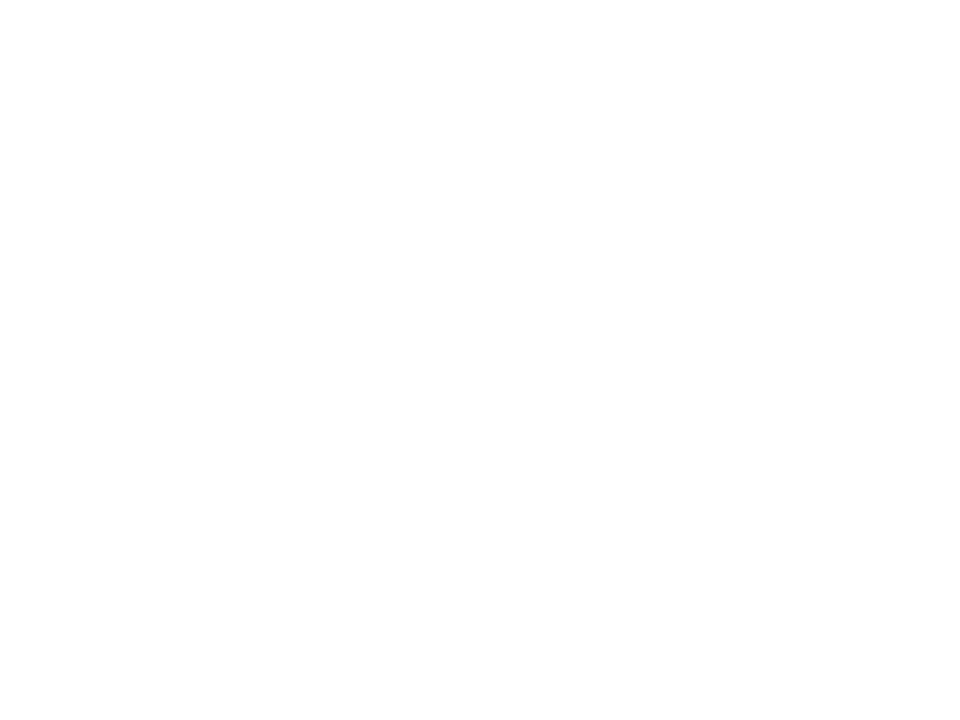

NameError: name 'history' is not defined

In [20]:
plt.figure()
plt.plot(history.history['loss'], label = "'Custo' do treino")
plt.plot(history.history['val_loss'], label= "'Custo' do teste")
plt.legend()
plt.show()

# Visualizando filtros da rede CNN

In [ ]:
# Obtem pesos da segunda camada
filters, biases = model.layers[1].get_weights()
# Normaliza valores entre 0 e 1
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 32, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, j], cmap='gray')
    ix += 1
# show the figure
plt.show()

# Avaliando modelo

__Carrega o melhor peso__

In [21]:
model.load_weights(checkDir)

__Acurácia média__

In [22]:
_, accuracy = model.evaluate(test_features, test_labels)
print("Acurácia do modelo nos dados de teste: %.2f%%" % (accuracy*100.0))

1025/1025 [==============================] - 5s 5ms/step - loss: 0.5726 - accuracy: 0.9348
Acurácia do modelo nos dados de teste: 93.48%


__Acurácia individual__

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(test_features, batch_size=256, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y = np.argmax(test_labels, axis=1)

129/129 [==============================] - 16s 75ms/step


In [24]:
cm = confusion_matrix(y, y_pred_bool)

<IPython.core.display.Javascript object>


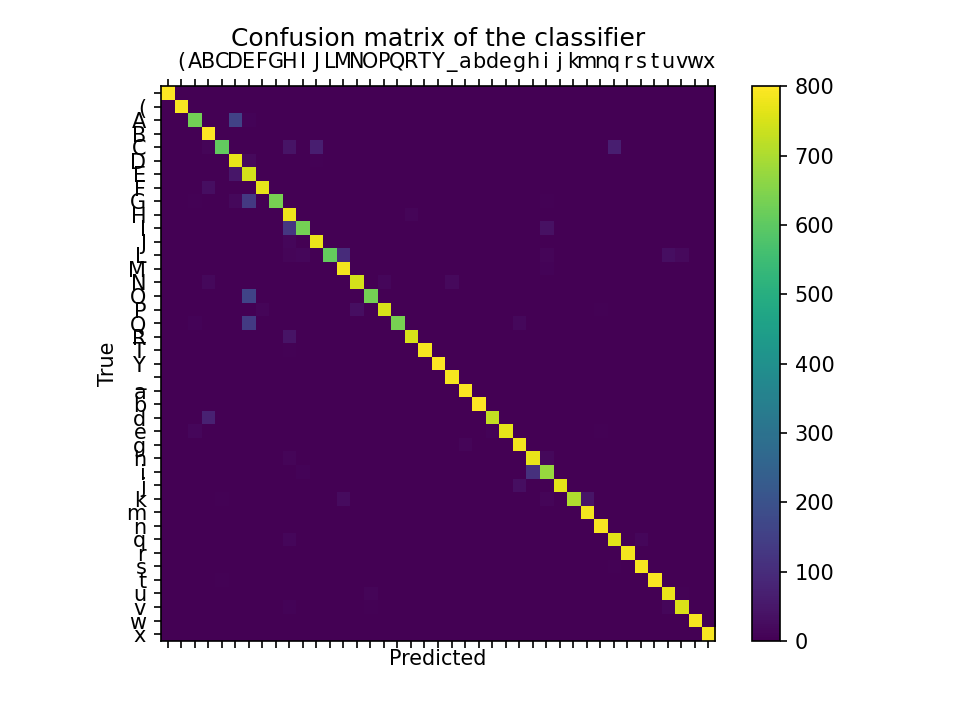

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticks(range(cm.shape[0]))
ax.set_yticks(range(cm.shape[1]))
ax.set_xticklabels([''] + list(data.classes))
ax.set_yticklabels([''] + list(data.classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
print(classification_report(y, y_pred_bool, target_names=data.classes))
# Precision = (previsão c correta)/(previsão c correta + previsão c em rótulo diferente)
# Recall = (previsão c correto)/(quantidade total de f's)

              precision    recall  f1-score   support

           (       1.00      1.00      1.00       800
           A       0.99      0.99      0.99       800
           B       0.94      0.79      0.86       800
           C       0.86      1.00      0.92       800
           D       0.97      0.76      0.85       800
           E       0.77      0.97      0.86       800
           F       0.62      0.94      0.74       800
           G       0.98      0.96      0.97       800
           H       0.99      0.79      0.88       800
           I       0.73      0.97      0.84       800
           J       0.95      0.79      0.87       800
           L       0.91      0.97      0.94       800
           M       0.99      0.76      0.86       800
           N       0.87      0.98      0.92       800
           O       0.96      0.93      0.95       800
           P       0.96      0.79      0.87       800
           Q       0.97      0.94      0.96       800
           R       0.99    

# Salvando modelo

In [28]:
modelDir = "model/"
model.save(modelDir)

with open(modelDir + "classes.txt",'w') as f:
    for c in data.classes:
        f.write(str(c) + " ")

INFO:tensorflow:Assets written to: model/assets


# Testando modelo

__MLP__

In [26]:
import cv2

# Função para carregar imagem
def loadImage(fileName, printImg = False):
    # Carrega a imagem e aplica um threshold para ficar igual
    # as imagens do treino
    img = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU) 

    # Ajusta o tamanho da imagem
    img = cv2.resize(img, (32,32))
    
    if printImg:
        plt.figure()
        plt.imshow(img, cmap='gray')
    
    return list(img.flatten().tolist())


def getChar(x):
    label = model.predict([x], batch_size=1)
    
    char = data.oneHotDecode(label)
    
    return char

__CNN__

In [40]:
import cv2

# Função para carregar imagem
def loadImage(fileName, printImg = False):
    # Carrega a imagem e aplica um threshold para ficar igual
    # as imagens do treino
    img = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    #_, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)

    # Ajusta o tamanho da imagem
    img = cv2.resize(img, (32,32))
    
    if printImg:
        plt.figure()
        plt.imshow(img, cmap='gray')
        
    img = img.reshape((1,32,32,1))
    
    return img


def getChar(x):
    label = model.predict(x, batch_size=1)
    
    char = data.oneHotDecode(label)
    
    return char

In [30]:
x = loadImage("testes/letraa.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi a


In [31]:
x = loadImage("testes/letraa3.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi d


In [32]:
x = loadImage("testes/letra.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi g


In [33]:
x = loadImage("testes/letraAu.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi A


In [34]:
x = loadImage("testes/cidilha.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi e


In [35]:
x = loadImage("testes/cidilhau.png")
c = getChar(x)
print("O caractere reconhecido foi %s" % c)

O caractere reconhecido foi G


<IPython.core.display.Javascript object>


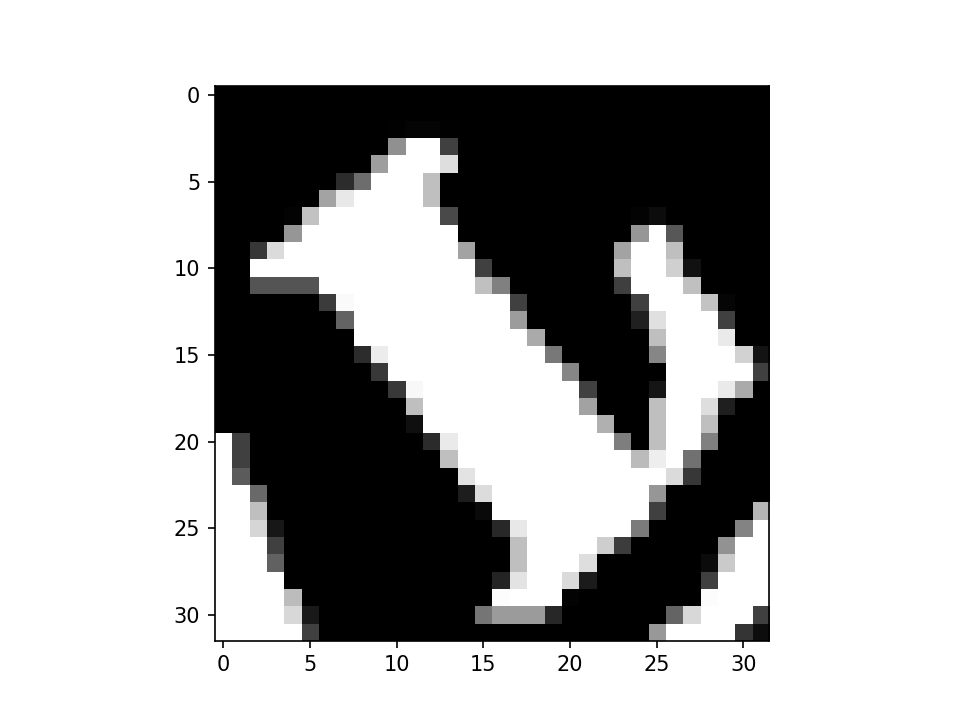

O caractere reconhecido foi L


In [41]:
x = loadImage("testes/real7.png", True)
c = getChar(x)
print("O caractere reconhecido foi %s" % c)